# Third-level GLM using Nipype FSL

In this notebook, we recreate the third-level GLM of FSL GUI using nipype code. For each nipype node, we list the corresponding fsl command from the log file. The dataset we use is a Flanker task, which can be downloaded [here](https://openneuro.org/datasets/ds000102/versions/00001).

We also borrow some helps from this [document](https://nipype.readthedocs.io/en/latest/users/examples/fmri_fsl.html). 

## Preparation
Import all the relevant libraries needed for the preprocessing stage.

In [17]:
from __future__ import print_function
from __future__ import division
from builtins import str
from builtins import range

import os, stat  # system functions
import getpass
from glob import glob

import numpy as np
from nipype import Function
from nipype.interfaces import fsl, utility as util, io as nio
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.modelgen as model  # model generation
import nipype.algorithms.rapidart as ra  # artifact detection

# this one is for `cluster` see this issue https://github.com/nipy/nipype/issues/1415
fsl.FSLCommand._cmd_prefix = '/opt/fsl-6.0.4/bin/'

%autosave 5

Autosaving every 5 seconds


Set up data path

In [ ]:
# Get current user
user = getpass.getuser()
print('Running code as: ', user)

# Input: Set the second-level result path
data_dir = '/home/{}/out/fsl/nipype_output/level2_results/'.format(user)
# Output: Set path where nipype will store stepwise results
exp_dir = '/home/{}/out/fsl/nipype_output/'.format(user)

try:
    os.mkdir(exp_dir)
except OSError as error:
    print(error)
    
    
# Grant root write access to our output files 
os.chmod(exp_dir, os.stat(exp_dir).st_mode | ((stat.S_IRWXU | stat.S_IRWXO)))

Start the workflow

In [3]:
wf = pe.Workflow(name='level3', base_dir=exp_dir)
wf.config["execution"]["crashfile_format"] = "txt"

The following two nodes (`infosource` & `dg`) together define all inputs required for the preprocessing workflow

In [4]:
# we want to group the outcome by contrast not subject
contr_list = [1,2,3,4]
infosource = pe.Node(util.IdentityInterface(fields=["contr_id"]),
                  name="infosource")
infosource.iterables = [("contr_id", contr_list)]

In [5]:
# here we use SelectFiles, instead of DataGrabber, because the former is more flexible with formatting syntax
templates = {
    "copes":"contrast_{contr_id}/*/_contr_id_{contr_id}/*/cope*.nii.gz",
    "varcopes":"contrast_{contr_id}/*/_contr_id_{contr_id}/*/varcope*.nii.gz",
    "masks":"contrast_{contr_id}/*/_contr_id_{contr_id}/*/mask.nii.gz"
}
dg = pe.Node(interface=nio.SelectFiles(templates),
             name="selectfiles")
dg.inputs.base_directory = data_dir

wf.connect([
        (infosource, dg, [("contr_id", "contr_id")])
])

## Third-level GLM

Combining results from multiple runs of one subject into one

### Higher-level input files preparation

#### Step 1: Merge registered copes & varcopes & masks


**Corresponding FSL command:**
```
/usr/local/fsl/bin/fslmerge -t mask (masks from all 26 inputs)
/usr/local/fsl/bin/fslmerge -t cope (copes from all 26 inputs)
/usr/local/fsl/bin/fslmerge -t varcop (varcopes from all 26 inputs)
```

In [6]:
copemerge = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="copemerge")

varcopemerge = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="varcopemerge")

maskmerge = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="maskmerge")


def repeat_mask(file):
    n_sub = 26
    import numpy as np
    mask_lst = [file]
    repeated = np.repeat(mask_lst,26)
    return list(repeated)


wf.connect(dg, 'copes', copemerge, 'in_files')
wf.connect(dg, 'varcopes', varcopemerge, 'in_files')
wf.connect(dg, ('masks',repeat_mask), maskmerge, 'in_files')

#### Step 2: Making mask

In FSL, there are many commands about `maskunique`, which is unless for the second level. We can ignore it.

**Corresponding FSL command:**
```
/usr/local/fsl/bin/fslmaths mask -Tmin mask
```

In [7]:
# /usr/local/fsl/bin/fslmaths mask -Tmin mask
minmask = pe.Node(
    interface=fsl.ImageMaths(op_string='-Tmin'),
    iterfield=['in_file'],
    name='minmask')

wf.connect(maskmerge, 'merged_file', minmask, 'in_file')


#### Step 3: Masking copes & varcopes

**Corresponding FSL command:**

we have four contrasts so the following commands repeat four times

```
/usr/local/fsl/bin/fslmaths cope1 -mas mask cope1
/usr/local/fsl/bin/fslmaths varcope1 -mas mask varcope1
```

In [8]:
maskcope = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskcope')

maskvarcope = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskvarcope')

wf.connect(copemerge, 'merged_file', maskcope, 'in_file')
wf.connect(minmask, 'out_file', maskcope, 'in_file2')
wf.connect(varcopemerge, 'merged_file', maskvarcope, 'in_file')
wf.connect(minmask, 'out_file', maskvarcope, 'in_file2')

### Set up third-level contrasts

Since we only have a single-group set-up, we can actually use [L2Model](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#l2model).
If we have an ANOVA-like design, using [MultipleRegressDesign](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#multipleregressdesign) would be a better option.

In [9]:
def num_copes(files):
    return len(files)

level3model = pe.Node(interface=fsl.L2Model(), name='l3model')
wf.connect(dg, ('copes',num_copes), level3model, 'num_copes')

In [10]:
level3estimate = pe.Node(
    interface=fsl.FLAMEO(run_mode='flame1'),
    name="level3estimate",
    iterfield=['cope_file', 'var_cope_file'])

wf.connect([
    (maskcope, level3estimate, [('out_file', 'cope_file')]),
    (maskvarcope, level3estimate, [('out_file', 'var_cope_file')]),
    (minmask, level3estimate, [('out_file', 'mask_file')]),
    (level3model, level3estimate, [('design_mat', 'design_file'),
                                   ('design_con', 't_con_file'), 
                                   ('design_grp', 'cov_split_file')]),
])

### Post-Stats

#### Smoothness estimation

to get `dlh` and `volume` for thresholding

**Corresponding FSL command:**

```
/usr/local/fsl/bin/smoothest -d 25 -m mask -r stats/res4d > stats/smoothness
```

In [11]:
smoothest = pe.Node(
    interface=fsl.SmoothEstimate(dof=25),
    name="smoothest",
    iterfield=['residual_fit_file', 'mask_file'])

wf.connect(minmask, 'out_file', smoothest, 'mask_file')
wf.connect(level3estimate, 'res4d', smoothest, 'residual_fit_file')

#### Mask zstats file

preparation for thresholding

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths stats/zstat1 -mas mask thresh_zstat1
```

In [12]:
level3mask = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file','in_file2'],
    name='level3mask')

wf.connect([
    (level3estimate,level3mask,[('zstats', 'in_file')]),
    (minmask, level3mask, [('out_file', 'in_file2')]),
])

#### Cluster-wise thresholding

**Corresponding FSL command:**

```
/usr/local/fsl/bin/cluster -i thresh_zstat1 -t 3.1 --othresh=thresh_zstat1 -o cluster_mask_zstat1 --connectivity=26 --mm --olmax=lmax_zstat1_std.txt --scalarname=Z -p 0.05 -d 0.0595781 --volume=254734 -c stats/cope1 > cluster_zstat1_std.txt
```

In [13]:
level3threshold = pe.Node(
        interface=fsl.Cluster(threshold = 3.1,
                              pthreshold = 0.05,
                              use_mm = True,
                              out_threshold_file =True,
                              out_index_file = True,
                              out_localmax_txt_file = True),
    iterfield=['in_file','cope_file'],
    name='level3threshold')

wf.connect([
    (level3mask, level3threshold, [('out_file', 'in_file')]),
    (level3estimate, level3threshold, [('copes', 'cope_file')]),
    (smoothest, level3threshold, [('dlh', 'dlh'),
                                   ('volume', 'volume')]),
])

## Save the output

In [14]:
datasink = pe.Node(nio.DataSink(), name='sinker')
datasink.inputs.base_directory=os.path.join(exp_dir, "level3_results")

int2string = lambda x: 'contrast_'+str(x)
    
wf.connect(infosource, ('contr_id',int2string), datasink, 'container')
wf.connect([
    (level3estimate, datasink, [('stats_dir', 'stats_dir')]),
    (level3threshold, datasink, [('threshold_file', 'thresholded'),
                                ('localmax_txt_file', 'localmax_txt'),
                                ('index_file', 'index')]),
           ])

220323-10:28:14,822 nipype.workflow INFO:
	 Generated workflow graph: /home/yc/out/fsl/nipype_output/level3/graph.png (graph2use=colored, simple_form=True).


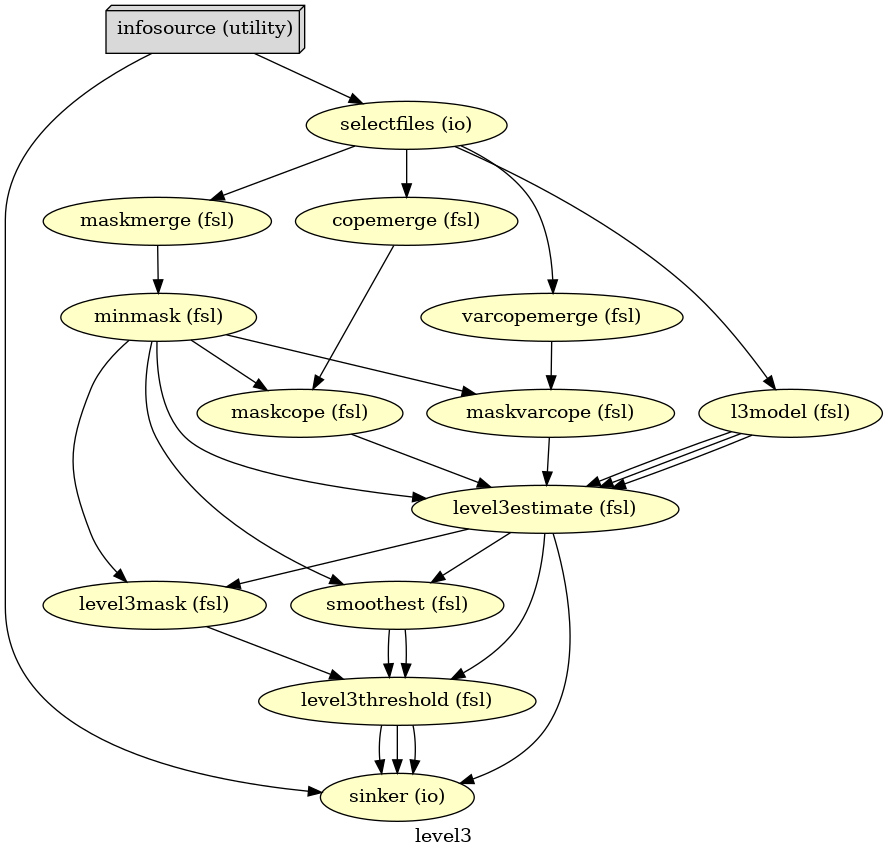

In [15]:
# Create 1st-level analysis output graph
wf.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(wf.base_dir, wf.name, 'graph.png'))

In [16]:
# Run Workflow
wf.run(plugin="MultiProc", plugin_args={"n_procs": 8})

220323-10:28:14,844 nipype.workflow INFO:
	 Workflow level3 settings: ['check', 'execution', 'logging', 'monitoring']
220323-10:28:14,913 nipype.workflow INFO:
	 Running in parallel.
220323-10:28:14,916 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 27.96/27.96, Free processors: 8/8.
220323-10:28:14,982 nipype.workflow INFO:
	 [Node] Setting-up "level3.selectfiles" in "/home/yc/out/fsl/nipype_output/level3/_contr_id_4/selectfiles".
220323-10:28:14,984 nipype.workflow INFO:
	 [Node] Setting-up "level3.selectfiles" in "/home/yc/out/fsl/nipype_output/level3/_contr_id_3/selectfiles".
220323-10:28:14,986 nipype.workflow INFO:
	 [Node] Setting-up "level3.selectfiles" in "/home/yc/out/fsl/nipype_output/level3/_contr_id_2/selectfiles".
220323-10:28:14,988 nipype.workflow INFO:
	 [Node] Setting-up "level3.selectfiles" in "/home/yc/out/fsl/nipype_output/level3/_contr_id_1/selectfiles".
220323-10:28:15,4 nipype.workflow INFO:
	 [Node] Running "selectfiles